In [1]:
# # Need to limit number of cores used
# import os
# os.environ['MKL_NUM_THREADS'] = '1'

In [32]:
#Load Libraries
import pandas as pd
import sqlite3 as sqlite3
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from xgboost import XGBClassifier

### Data Preparation

In [3]:
# Load the data into a DataFrame

con = sqlite3.connect("data/wildfire.sqlite")
fires = pd.read_sql_query(
    "select NWCG_REPORTING_AGENCY,CONT_DATE - DISCOVERY_DATE as CONT_TIME, \
    LONGITUDE,LATITUDE,OWNER_CODE,SOURCE_SYSTEM_TYPE,DISCOVERY_DATE,\
    DISCOVERY_DOY,STAT_CAUSE_DESCR,FIRE_SIZE from fires", con)
con.close()

In [4]:
fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880465 entries, 0 to 1880464
Data columns (total 10 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   NWCG_REPORTING_AGENCY  object 
 1   CONT_TIME              float64
 2   LONGITUDE              float64
 3   LATITUDE               float64
 4   OWNER_CODE             float64
 5   SOURCE_SYSTEM_TYPE     object 
 6   DISCOVERY_DATE         float64
 7   DISCOVERY_DOY          int64  
 8   STAT_CAUSE_DESCR       object 
 9   FIRE_SIZE              float64
dtypes: float64(6), int64(1), object(3)
memory usage: 143.5+ MB


In [5]:
fires = fires.drop_duplicates()
fires.shape

(1874345, 10)

In [6]:
fires = fires.dropna()
fires.shape

(985182, 10)

In [7]:
fires1 = fires[(fires["STAT_CAUSE_DESCR"] != "Missing/Undefined") & (fires["STAT_CAUSE_DESCR"] != "Miscellaneous")]
fires1.shape

(751420, 10)

<Axes: >

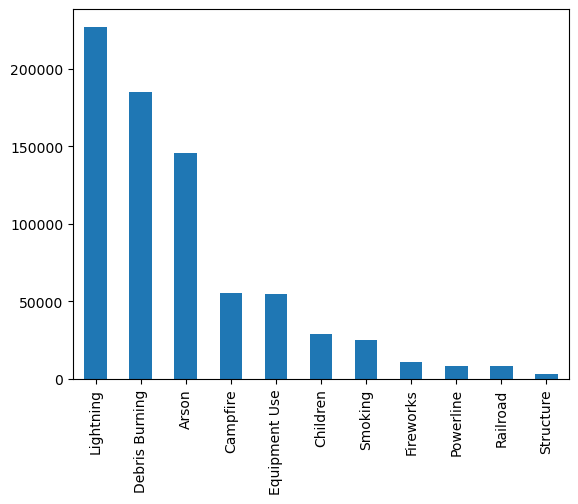

In [8]:
fires1["STAT_CAUSE_DESCR"].value_counts().plot.bar()


In [9]:
xFires=fires1.loc[:,fires1.columns != 'STAT_CAUSE_DESCR']
yFires=fires1['STAT_CAUSE_DESCR']

#Training and test set split
xTrain,xTest,yTrain,yTest=train_test_split(xFires,yFires,\
                           test_size=0.1,random_state =441)

xTrain.shape
# yTrain.shape

(676278, 9)

In [10]:
counts = yTrain.value_counts()
counts

Lightning         204604
Debris Burning    166208
Arson             130883
Campfire           49611
Equipment Use      49097
Children           26230
Smoking            22438
Fireworks           9414
Powerline           7564
Railroad            7485
Structure           2744
Name: STAT_CAUSE_DESCR, dtype: int64

<Axes: >

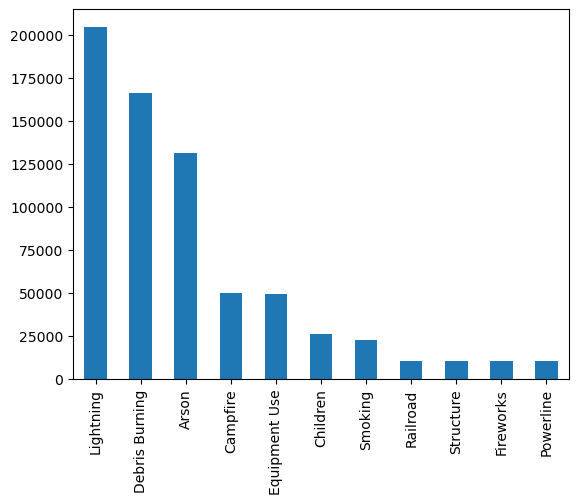

In [11]:
from imblearn.over_sampling import RandomOverSampler

def count_under_10000(colname):
    if counts[colname] < 10000:
        return 10000
    return counts[colname]

#Perform undersampling
OverSampleRatio = {
    'Lightning' : count_under_10000('Lightning'), 'Debris Burning' : count_under_10000('Debris Burning'), 'Campfire' : count_under_10000('Campfire'), 
    'Equipment Use' : count_under_10000('Equipment Use'),    
    'Arson' : count_under_10000('Arson'), 'Children' : count_under_10000('Children'), 'Railroad' : count_under_10000('Railroad'),
    'Smoking' : count_under_10000('Smoking'), 'Powerline' : count_under_10000('Powerline'),
    'Fireworks' : count_under_10000('Fireworks'), 'Structure' : count_under_10000('Structure')
}

newSampStrat=RandomOverSampler(sampling_strategy=OverSampleRatio,random_state=441) #Goal balance all classes
xTrain,yTrain=newSampStrat.fit_resample(xTrain,yTrain) #perform the balancing newX and newY are balanced X and y
yTrain.value_counts().plot.bar()  #print result showing the nunmber of observation in each class

In [12]:
counts = yTrain.value_counts()
counts

Lightning         204604
Debris Burning    166208
Arson             130883
Campfire           49611
Equipment Use      49097
Children           26230
Smoking            22438
Railroad           10000
Structure          10000
Fireworks          10000
Powerline          10000
Name: STAT_CAUSE_DESCR, dtype: int64

<Axes: >

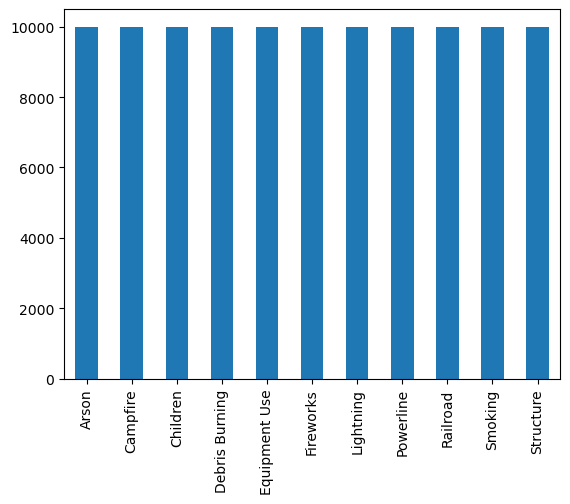

In [13]:
from imblearn.under_sampling import RandomUnderSampler


newSampStrat=RandomUnderSampler(sampling_strategy='not minority',random_state=441) #Goal balance all classes
xTrain,yTrain=newSampStrat.fit_resample(xTrain,yTrain) #perform the balancing newX and newY are balanced X and y
yTrain.value_counts().plot.bar() 

In [14]:
yTrain.value_counts()

Arson             10000
Campfire          10000
Children          10000
Debris Burning    10000
Equipment Use     10000
Fireworks         10000
Lightning         10000
Powerline         10000
Railroad          10000
Smoking           10000
Structure         10000
Name: STAT_CAUSE_DESCR, dtype: int64

### Feature Engineering

In [15]:
xTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110000 entries, 0 to 109999
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   NWCG_REPORTING_AGENCY  110000 non-null  object 
 1   CONT_TIME              110000 non-null  float64
 2   LONGITUDE              110000 non-null  float64
 3   LATITUDE               110000 non-null  float64
 4   OWNER_CODE             110000 non-null  float64
 5   SOURCE_SYSTEM_TYPE     110000 non-null  object 
 6   DISCOVERY_DATE         110000 non-null  float64
 7   DISCOVERY_DOY          110000 non-null  int64  
 8   FIRE_SIZE              110000 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 7.6+ MB


In [16]:
xTrain.DISCOVERY_DATE

0         2451792.5
1         2452599.5
2         2456241.5
3         2450015.5
4         2448943.5
            ...    
109995    2456059.5
109996    2454258.5
109997    2453700.5
109998    2455643.5
109999    2455900.5
Name: DISCOVERY_DATE, Length: 110000, dtype: float64

In [17]:
#list for cols to scale
cols_to_scale = ['CONT_TIME','LONGITUDE', 'LATITUDE', 'DISCOVERY_DATE', 'DISCOVERY_DOY', "FIRE_SIZE"]

#create and fit scaler
scaler = StandardScaler()
scaler.fit(xTrain[cols_to_scale])

#scale selected data
xTrain[cols_to_scale] = scaler.transform(xTrain[cols_to_scale])

In [18]:
# #create and fit scaler
# scaler = StandardScaler()
# scaler.fit(xTest[cols_to_scale])

#scale selected data
xTest[cols_to_scale] = scaler.transform(xTest[cols_to_scale])

In [19]:
# OHE for categorical variables
xTrain_model = pd.get_dummies(xTrain, columns = ["NWCG_REPORTING_AGENCY", "OWNER_CODE", "SOURCE_SYSTEM_TYPE"])
xTrain_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110000 entries, 0 to 109999
Data columns (total 31 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   CONT_TIME                     110000 non-null  float64
 1   LONGITUDE                     110000 non-null  float64
 2   LATITUDE                      110000 non-null  float64
 3   DISCOVERY_DATE                110000 non-null  float64
 4   DISCOVERY_DOY                 110000 non-null  float64
 5   FIRE_SIZE                     110000 non-null  float64
 6   NWCG_REPORTING_AGENCY_BIA     110000 non-null  uint8  
 7   NWCG_REPORTING_AGENCY_BLM     110000 non-null  uint8  
 8   NWCG_REPORTING_AGENCY_FS      110000 non-null  uint8  
 9   NWCG_REPORTING_AGENCY_FWS     110000 non-null  uint8  
 10  NWCG_REPORTING_AGENCY_NPS     110000 non-null  uint8  
 11  NWCG_REPORTING_AGENCY_ST/C&L  110000 non-null  uint8  
 12  NWCG_REPORTING_AGENCY_TRIBE   110000 non-nul

In [20]:
xTest_model = pd.get_dummies(xTest, columns = ["NWCG_REPORTING_AGENCY", "OWNER_CODE", "SOURCE_SYSTEM_TYPE"])
# xTest_model.info()

In [21]:
# keeping only same columns as xTrain
cols_to_keep = [col for col in xTest_model.columns if col in xTrain_model.columns]
xTest_model = xTest_model[cols_to_keep]
xTest_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75142 entries, 344960 to 328478
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   CONT_TIME                     75142 non-null  float64
 1   LONGITUDE                     75142 non-null  float64
 2   LATITUDE                      75142 non-null  float64
 3   DISCOVERY_DATE                75142 non-null  float64
 4   DISCOVERY_DOY                 75142 non-null  float64
 5   FIRE_SIZE                     75142 non-null  float64
 6   NWCG_REPORTING_AGENCY_BIA     75142 non-null  uint8  
 7   NWCG_REPORTING_AGENCY_BLM     75142 non-null  uint8  
 8   NWCG_REPORTING_AGENCY_FS      75142 non-null  uint8  
 9   NWCG_REPORTING_AGENCY_FWS     75142 non-null  uint8  
 10  NWCG_REPORTING_AGENCY_NPS     75142 non-null  uint8  
 11  NWCG_REPORTING_AGENCY_ST/C&L  75142 non-null  uint8  
 12  NWCG_REPORTING_AGENCY_TRIBE   75142 non-null  uint8  


In [22]:
# Encode classes
lc = LabelEncoder() 

lc_yTrain = lc.fit_transform(yTrain) 
lc_yTrain

lc_yTest = lc.transform(yTest) 
lc_yTest


array([6, 3, 0, ..., 3, 3, 6])

In [23]:
lc.get_params()

{}

### Model Training

In [24]:
params = {
        #'gamma': [0.3, 1],
        'max_depth': [40, 100],
        'n_estimators' : [200, 500],
#        'learning_rate' : [0.01, 0.1, 0.9],
        'random_state' : [441],
        'reg_alpha' : [0.5]
        }

# params = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5],
#         'n_estimators' : [100, 300]
#         }

In [25]:
estimator = XGBClassifier(objective = "multi:softprob") 

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=params,
    scoring = 'accuracy',
    #n_jobs = ,
    cv = 5,
    verbose=4,
    refit = True
)

grid_search.fit(xTrain_model, lc_yTrain)

# model.fit(xTrain_model, lc_yTrain)

# yPred = model.predict(xTest) 

# yPred = [round(value) for value in yPred]

# accuracy = accuracy_score(lc_yTest, yPred) 

# print("Accuracy: %.2f%%" % (accuracy * 100.0))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END max_depth=40, n_estimators=200, random_state=441, reg_alpha=0.5;, score=0.577 total time= 3.3min
[CV 2/5] END max_depth=40, n_estimators=200, random_state=441, reg_alpha=0.5;, score=0.581 total time= 3.3min
[CV 3/5] END max_depth=40, n_estimators=200, random_state=441, reg_alpha=0.5;, score=0.585 total time= 3.3min
[CV 4/5] END max_depth=40, n_estimators=200, random_state=441, reg_alpha=0.5;, score=0.578 total time= 3.3min
[CV 5/5] END max_depth=40, n_estimators=200, random_state=441, reg_alpha=0.5;, score=0.591 total time= 3.4min
[CV 1/5] END max_depth=40, n_estimators=500, random_state=441, reg_alpha=0.5;, score=0.576 total time= 5.9min
[CV 2/5] END max_depth=40, n_estimators=500, random_state=441, reg_alpha=0.5;, score=0.581 total time= 5.8min
[CV 3/5] END max_depth=40, n_estimators=500, random_state=441, reg_alpha=0.5;, score=0.585 total time= 5.7min
[CV 4/5] END max_depth=40, n_estimators=500, random_state=44

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softprob', predictor=None, ...),
             param_grid={'max_depth': [40, 100], 'n_estimators': [200, 500],
                         'random_state': [441], 'reg_alpha': [0.5]},
             scoring='accuracy', verbose=4)

In [26]:
grid_search.cv_results_

{'mean_fit_time': array([198.69944201, 348.5567255 , 206.76943631, 361.28751945]),
 'std_fit_time': array([0.98861223, 4.96893646, 4.96398216, 6.12617509]),
 'mean_score_time': array([0.68287086, 1.01554275, 0.64907207, 1.04656472]),
 'std_score_time': array([0.08606839, 0.03380466, 0.0627487 , 0.09644508]),
 'param_max_depth': masked_array(data=[40, 40, 100, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[200, 500, 200, 500],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_random_state': masked_array(data=[441, 441, 441, 441],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_reg_alpha': masked_array(data=[0.5, 0.5, 0.5, 0.5],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 40,
   'n_estima

In [34]:
print("The best training accuracy score is ", grid_search.best_score_ * 100, "%")

The best training accuracy score is  58.2890909090909 %


In [28]:
print("The best parameter combination is:\n ", grid_search.best_params_)

The best parameter combination is:
  {'max_depth': 100, 'n_estimators': 200, 'random_state': 441, 'reg_alpha': 0.5}


#### Predicting on the test set to get final accuracy

In [29]:
final_model = grid_search.best_estimator_

In [35]:
yPred = final_model.predict(xTest_model) 

yPred = [round(value) for value in yPred]

accuracy = accuracy_score(lc_yTest, yPred) 

print("Test Accuracy: %.2f%%" % (accuracy * 100.0))

Test Accuracy: 52.85%


Text(0.5, 1.0, 'Variable Importance for XGBoost Classifier')

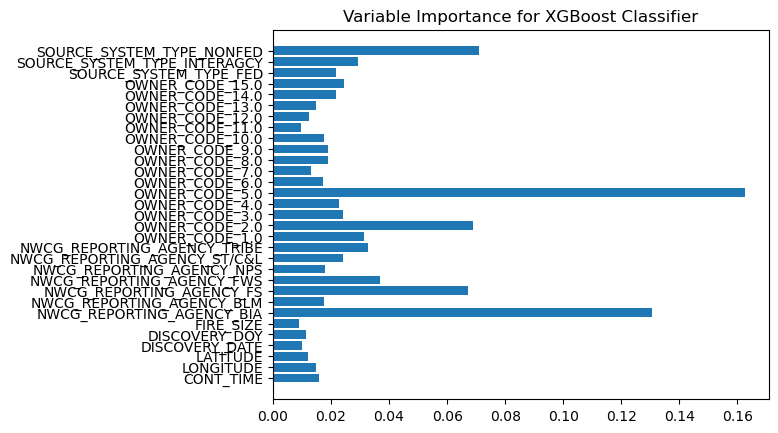

In [36]:
plt.barh(xTrain_model.columns, final_model.feature_importances_)
plt.title('Variable Importance for XGBoost Classifier')